In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!gdown 16-YMcllOpkUmAhOAzwQqN0S7446G0Fvq


Downloading...
From: https://drive.google.com/uc?id=16-YMcllOpkUmAhOAzwQqN0S7446G0Fvq
To: /content/euro.zip
100% 23.0M/23.0M [00:00<00:00, 30.8MB/s]


In [ ]:
!unzip euro.zip -d /content/dataset/


In [16]:

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms


In [14]:

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [18]:
import helper_functions

In [22]:
import importlib
import helper_functions
importlib.reload(helper_functions)

from helper_functions import set_seeds  # Try importing again


In [24]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
class_names = [
    'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
    'Industrial', 'Pasture', 'PermanentCrop', 'Residential',
    'River', 'SeaLake'
]


set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

In [27]:
!pip install torchinfo
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 10]             768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [28]:
# Setup directory paths to train and test images
train_dir = '/content/dataset/euro/train'
test_dir = '/content/dataset/euro/test'

In [29]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [30]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [33]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)


In [35]:
import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2225 | train_acc: 0.9369 | test_loss: 0.2140 | test_acc: 0.9352
Epoch: 2 | train_loss: 0.1445 | train_acc: 0.9632 | test_loss: 0.1816 | test_acc: 0.9390
Epoch: 3 | train_loss: 0.1114 | train_acc: 0.9735 | test_loss: 0.1705 | test_acc: 0.9459
Epoch: 4 | train_loss: 0.0914 | train_acc: 0.9797 | test_loss: 0.1627 | test_acc: 0.9489
Epoch: 5 | train_loss: 0.0754 | train_acc: 0.9845 | test_loss: 0.1624 | test_acc: 0.9451
Epoch: 6 | train_loss: 0.0652 | train_acc: 0.9875 | test_loss: 0.1554 | test_acc: 0.9474
Epoch: 7 | train_loss: 0.0564 | train_acc: 0.9908 | test_loss: 0.1569 | test_acc: 0.9497
Epoch: 8 | train_loss: 0.0489 | train_acc: 0.9914 | test_loss: 0.1490 | test_acc: 0.9497
Epoch: 9 | train_loss: 0.0438 | train_acc: 0.9919 | test_loss: 0.1522 | test_acc: 0.9512
Epoch: 10 | train_loss: 0.0389 | train_acc: 0.9944 | test_loss: 0.1492 | test_acc: 0.9550


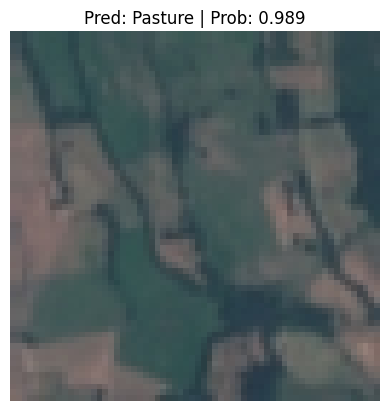

In [37]:
import requests
import predictions
# Import function to make predictions on images and plot them
from predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "test.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

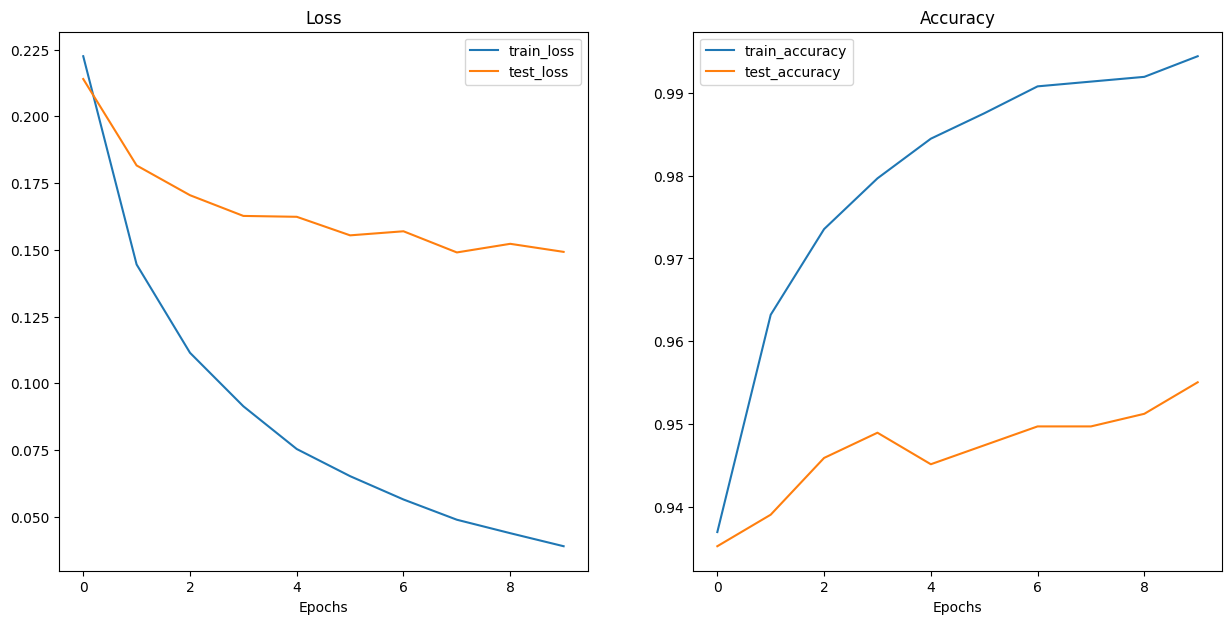

In [38]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [39]:
# Save the model's state_dict
torch.save(pretrained_vit.state_dict(), "pretrained_vit_model.pth")


In [40]:
# Save the entire model
torch.save(pretrained_vit, "vit_entire_model.pth")


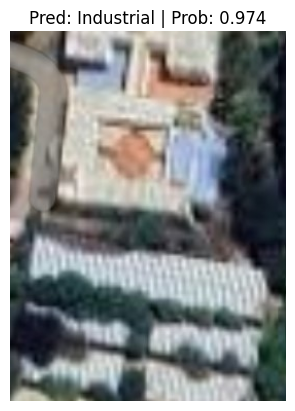

In [41]:
custom_image_path = "test1.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

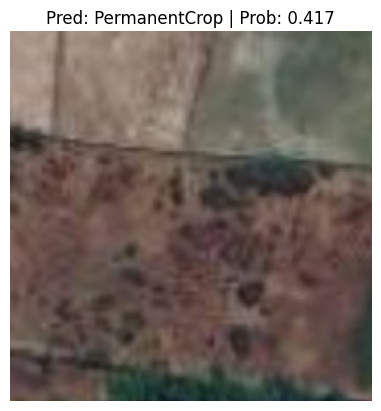

In [43]:
custom_image_path = "test3.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)